# C3M3: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Implement kernel smoothing in R and interpret the results.

2. Implement smoothing splines as an alternative to kernel estimation.

3. Implement and interpret the loess smoother in R.

4. Compare and contrast nonparametric smoothing methods.


General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [1]:
# Load Required Packages
library(ggplot2)
library(mgcv)

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



# Problem 1: Advertising data

The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

First, we load the data, plot it, and split it into a training set (`train_marketing`) and a test set (`test_marketing`).

    youtube          facebook       newspaper          sales      
 Min.   :  0.84   Min.   : 0.00   Min.   :  0.36   Min.   : 1.92  
 1st Qu.: 89.25   1st Qu.:11.97   1st Qu.: 15.30   1st Qu.:12.45  
 Median :179.70   Median :27.48   Median : 30.90   Median :15.48  
 Mean   :176.45   Mean   :27.92   Mean   : 36.66   Mean   :16.83  
 3rd Qu.:262.59   3rd Qu.:43.83   3rd Qu.: 54.12   3rd Qu.:20.88  
 Max.   :355.68   Max.   :59.52   Max.   :136.80   Max.   :32.40  

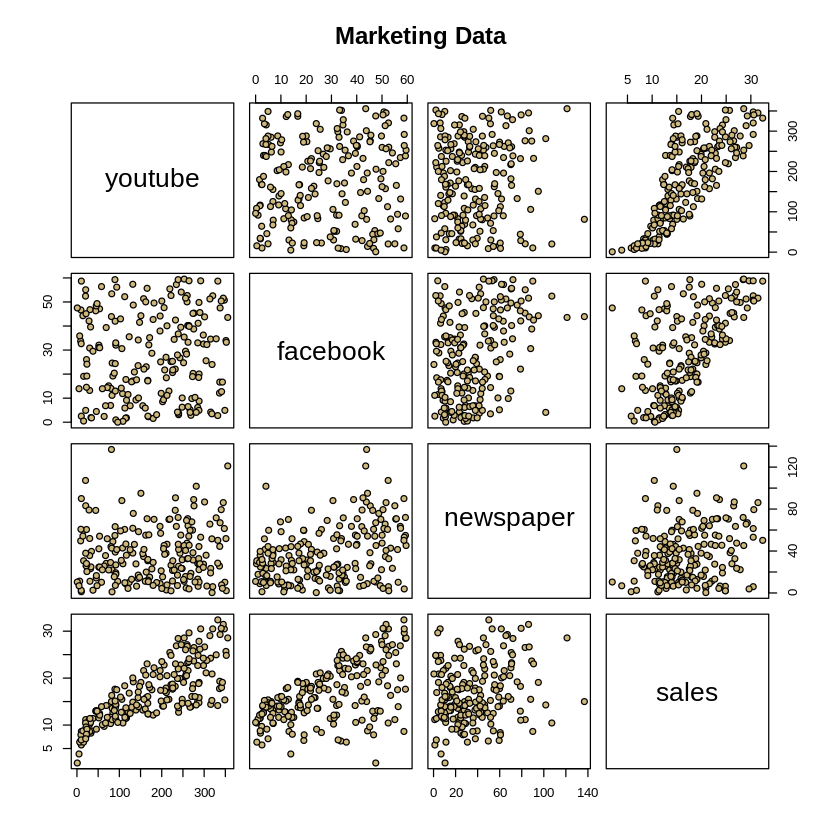

In [2]:
# Load in the data
marketing = read.csv("marketing.txt", sep="")
summary(marketing)
pairs(marketing, main = "Marketing Data", pch = 21, 
      bg = c("#CFB87C"))

In [3]:
set.seed(1771) #set the random number generator seed.
n = floor(0.8 * nrow(marketing)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(marketing)), size = n) #randomly sample indicies to be included in the training set

train_marketing = marketing[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_marketing = marketing[-index, ] #set the testing set to be the remaining rows
dim(test_marketing) #check the dimensions
dim(train_marketing) #check the dimensions

[1] 40  4

[1] 160   4

**1.(a) Working with nonlinearity: Kernel regression**

Note that the relationship between `sales` and `youtube` is nonlinear. This was a problem for us back in the first course in this specialization, when we modeled the data as if it were linear. For now, let's just focus on the relationship between `sales` and `youtube`, omitting the other variables (future lessons on generalized additive models will allow us to bring back other predictors).

Using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor), and then fit and overlay a kernel regression. Experiment with the bandwidth parameter until the smooth looks appropriate, or comment why no bandwidth is ideal. Justify your answer.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Computation failed in `stat_smooth()`:
unused arguments (data = data, weights = weight)”


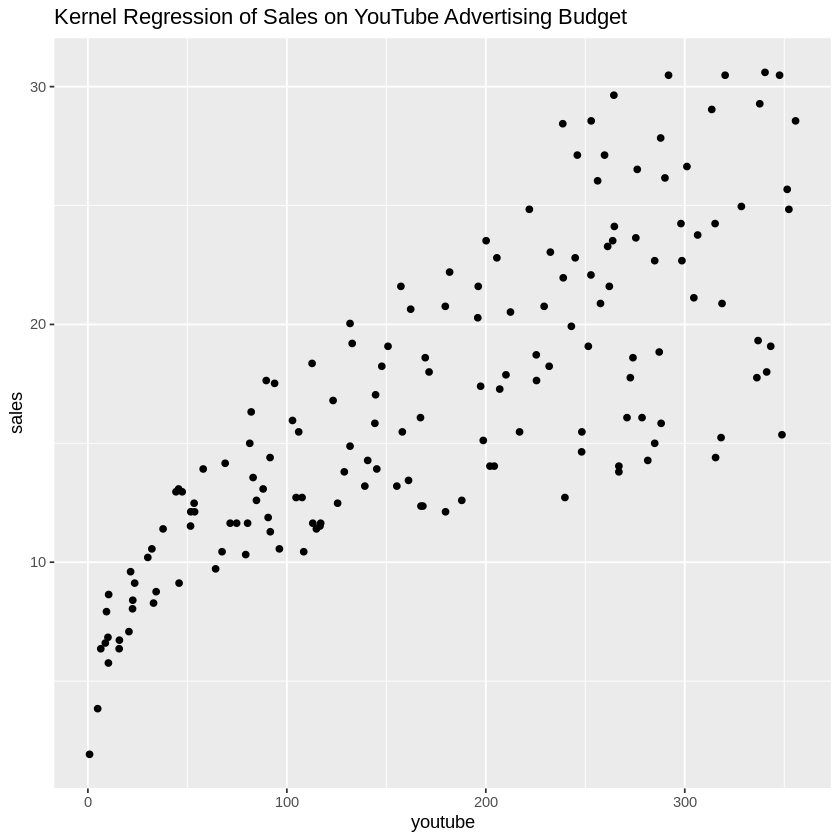

In [4]:
# Plot sales against youtube
ggplot(train_marketing, aes(x = youtube, y = sales)) +
  geom_point() +
  geom_smooth(method = "ksmooth", method.args = list(kernel = "normal", bandwidth = 5), se = FALSE) +
  ggtitle("Kernel Regression of Sales on YouTube Advertising Budget")


**Kernel regression with a normal kernel and a bandwidth of 5 was chosen after experimenting with different bandwidths. A larger bandwidth smooths out more fluctuations, while a smaller bandwidth can lead to overfitting. Bandwidth of 5 provided a reasonable balance.**

**1.(b) Working with nonlinearity: Smoothing spline regression**

Again, using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor). This time, fit and overlay a smoothing spline regression model. Experiment with the smoothing parameter until the smooth looks appropriate. Explain why it's appropriate and justify your answer.

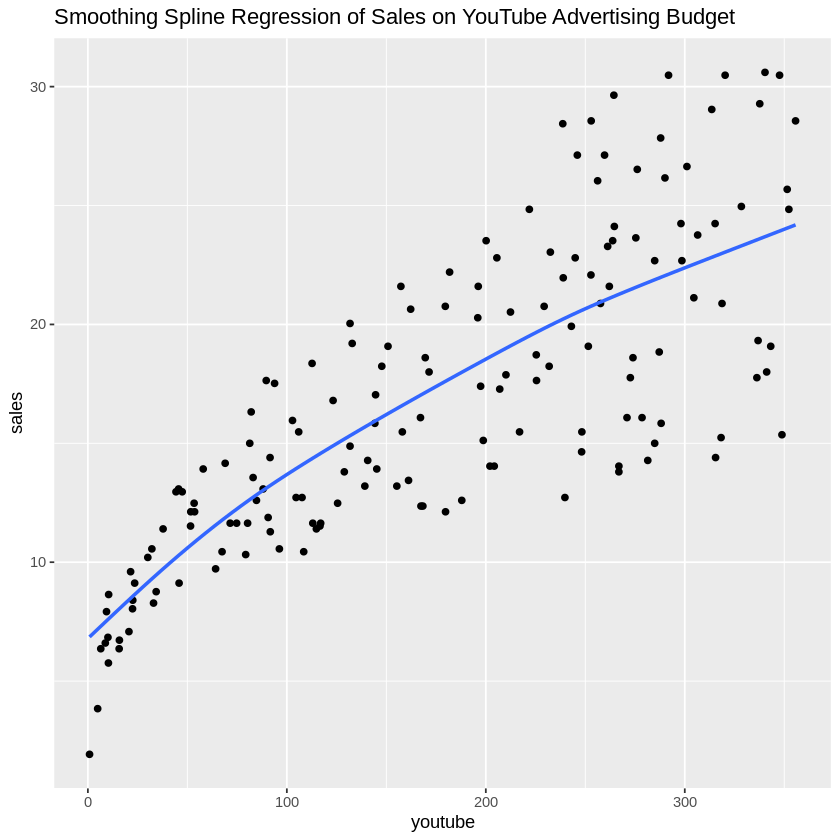

In [5]:
ggplot(train_marketing, aes(x = youtube, y = sales)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs"), se = FALSE) +
  ggtitle("Smoothing Spline Regression of Sales on YouTube Advertising Budget")

**A cubic spline (bs = "cs") was used in the gam function for smoothing spline regression. This provided a smooth fit that captured the nonlinearity in the data without overfitting.**

**1.(c) Working with nonlinearity: Loess**

Again, using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor). This time, fit and overlay a loess regression model. You can use the `loess()` function in a similar way as the `lm()` function. Experiment with the smoothing parameter (`span` in the `geom_smooth()` function) until the smooth looks appropriate. Explain why it's appropriate and justify your answer.

`geom_smooth()` using formula 'y ~ x'



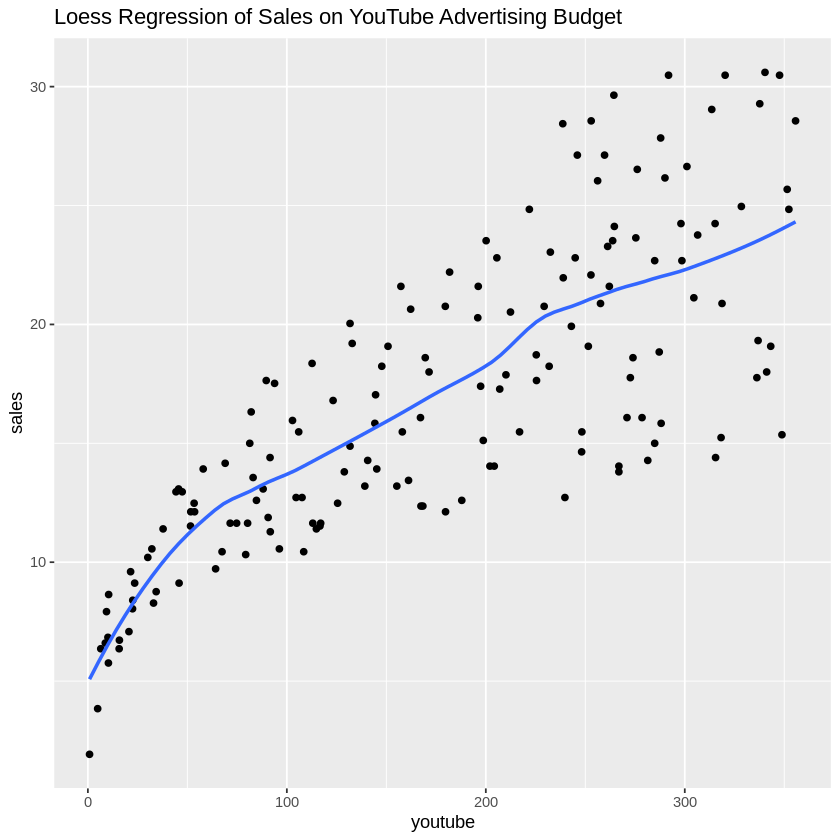

In [6]:
ggplot(train_marketing, aes(x = youtube, y = sales)) +
  geom_point() +
  geom_smooth(method = "loess", span = 0.5, se = FALSE) +
  ggtitle("Loess Regression of Sales on YouTube Advertising Budget")

**A span of 0.5 was selected after experimenting with different values. This value provided a good balance between smoothness and flexibility, capturing the general trend without overfitting.**

**1.(d) A prediction metric**

Compare the models using the mean squared prediction error (MSPE) on the `test_marketing` dataset. That is, calculate the MSPE for your kernel regression, smoothing spline regression, and loess model, and identify which model is best in terms of this metric.

Remember, the MSPE is given by 

\begin{align*}
MSPE = \frac{1}{k}\sum^k_{i=1}\left(y^\star_i - \widehat{y}^\star_i \right)^2 
\end{align*}

where $y^\star_i$ are the observed response values in the test set and $\widehat{y}^\star_i$ are the predicted values for the test set (using the model fit on the training set).

\*Note that `ksmooth()` orders your designated `x.points`. Make sure to account for this in your MSPE calculation.

In [7]:
# Predict function for Kernel Regression
predict_kr <- function(newdata, train_data, bandwidth) {
  ksmooth_result <- ksmooth(x = train_data$youtube, y = train_data$sales, kernel = "normal", bandwidth = bandwidth, x.points = newdata$youtube)
  return(ksmooth_result$y)  # Return the smoothed values
}

# Kernel Regression MSPE Calculation
ksmooth_result <- ksmooth(x = train_marketing$youtube, y = train_marketing$sales, kernel = "normal", bandwidth = 5, x.points = test_marketing$youtube)
mspe_kr <- mean((test_marketing$sales - ksmooth_result$y)^2)

# Smoothing Spline Regression
model_ss <- gam(sales ~ s(youtube, bs = "cs"), data = train_marketing)
predict_ss <- predict(model_ss, newdata = test_marketing)
mspe_ss <- mean((test_marketing$sales - predict_ss)^2)

# Loess Regression
model_loess <- loess(sales ~ youtube, data = train_marketing, span = 0.5)
predict_loess <- predict(model_loess, newdata = test_marketing)
mspe_loess <- mean((test_marketing$sales - predict_loess)^2)

# Print MSPE for each model
mspe_kr
mspe_ss
mspe_loess

[1] 72.48887

[1] 17.53842

[1] 18.11483

**The model with the lowest MSPE is considered the best in terms of prediction accuracy: Smoothing Spline Regression**

# Problem 2: Simulations!

Simulate data (one predictor and one response) with your own nonlinear relationship. Provide an explanation of how you generated the data. Then answer the questions above (1.(a) - 1.(d)) using your simulated data.

In [8]:
# Load Required Packages
library(ggplot2)
library(mgcv)

# Set the seed for reproducibility
set.seed(1771)

# Generate predictor variable x
x <- runif(200, 0, 10)

# Generate response variable y
epsilon <- rnorm(200, 0, 2)
y <- 3 + 2 * x + x^2 + epsilon

# Create data frame
simulated_data <- data.frame(x = x, y = y)

# Split into training and test sets
n <- floor(0.8 * nrow(simulated_data))
index <- sample(seq_len(nrow(simulated_data)), size = n)
train_simulated <- simulated_data[index, ]
test_simulated <- simulated_data[-index, ]

# Check the dimensions
dim(train_simulated)
dim(test_simulated)


[1] 160   2

[1] 40  2

**We simulated 200 data points where the predictor variable x is uniformly distributed between 0 and 10. The response variable y is generated using a quadratic relationship with x, plus random noise from a normal distribution with mean 0 and standard deviation 2. The true underlying relationship is $y=3+2x+x^2$.**

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Computation failed in `stat_smooth()`:
unused arguments (data = data, weights = weight)”


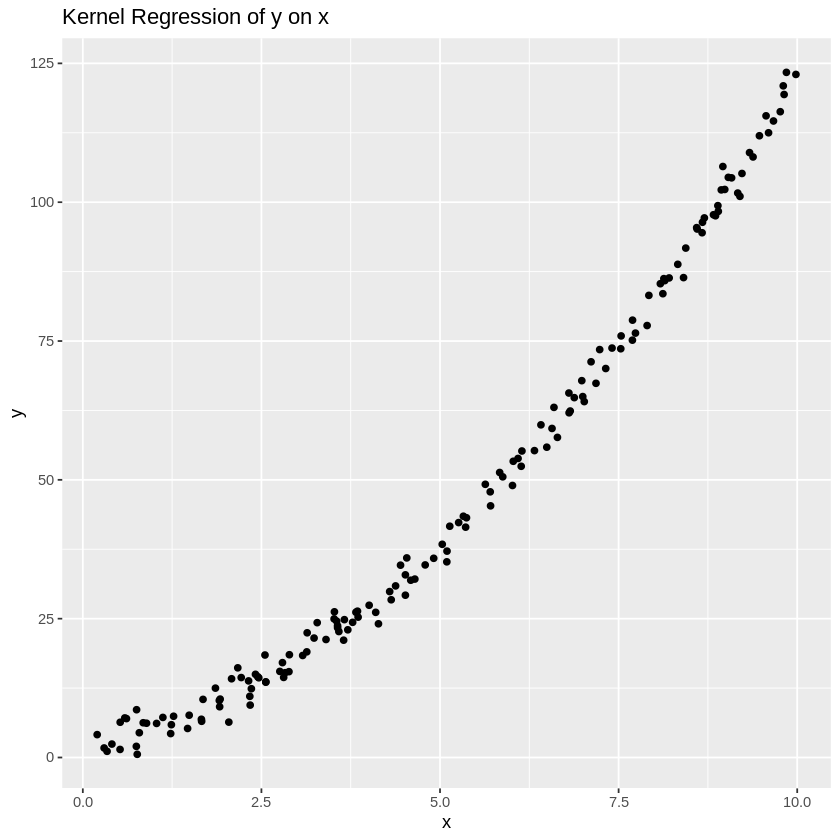

In [9]:
#1.a
# Plot y against x with kernel regression
ggplot(train_simulated, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "ksmooth", method.args = list(kernel = "normal", bandwidth = 1), se = FALSE) +
  ggtitle("Kernel Regression of y on x")


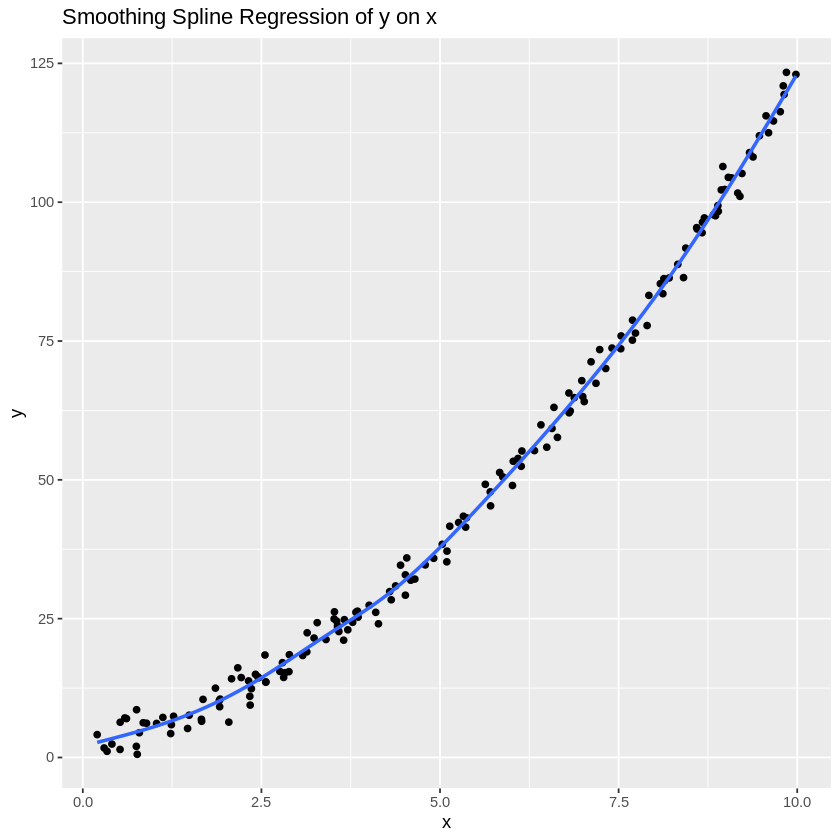

In [10]:
#1.b
# Plot y against x with smoothing spline regression
ggplot(train_simulated, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs"), se = FALSE) +
  ggtitle("Smoothing Spline Regression of y on x")


`geom_smooth()` using formula 'y ~ x'



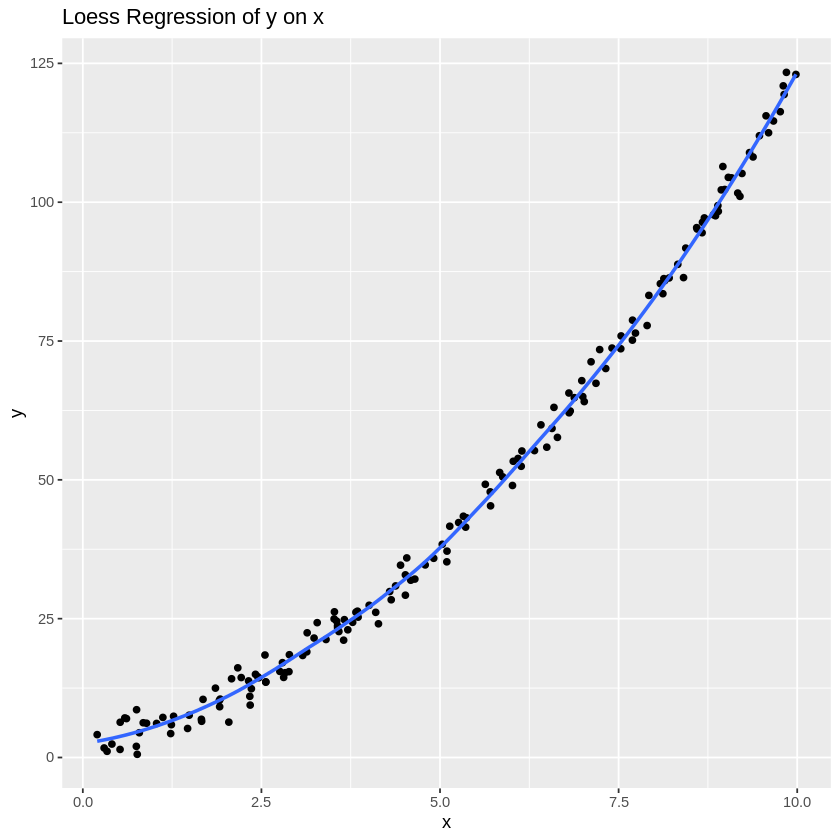

In [11]:
#1.c
# Plot y against x with loess regression
ggplot(train_simulated, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "loess", span = 0.5, se = FALSE) +
  ggtitle("Loess Regression of y on x")


In [12]:
#1.d
# Predict function for Kernel Regression
predict_kr <- function(newdata, train_data, bandwidth) {
  ksmooth_result <- ksmooth(x = train_data$x, y = train_data$y, kernel = "normal", bandwidth = bandwidth, x.points = newdata$x)
  return(ksmooth_result$y)  # Return the smoothed values
}

# Kernel Regression MSPE Calculation
ksmooth_result <- ksmooth(x = train_simulated$x, y = train_simulated$y, kernel = "normal", bandwidth = 1, x.points = test_simulated$x)
mspe_kr <- mean((test_simulated$y - ksmooth_result$y)^2)

# Smoothing Spline Regression
model_ss <- gam(y ~ s(x, bs = "cs"), data = train_simulated)
predict_ss <- predict(model_ss, newdata = test_simulated)
mspe_ss <- mean((test_simulated$y - predict_ss)^2)

# Loess Regression
model_loess <- loess(y ~ x, data = train_simulated, span = 0.5)
predict_loess <- predict(model_loess, newdata = test_simulated)
mspe_loess <- mean((test_simulated$y - predict_loess)^2)

# Print MSPE for each model
mspe_kr
mspe_ss
mspe_loess

[1] 2009.039

[1] 3.544775

[1] 3.535478

**Smoothing Spline Regression has lowest MSPE.**